In [ ]:
%pip install git+https://github.com/yfukai/BaSiCPy@autosegment

In [ ]:
%pip install matplotlib ray

# Install and import 

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [2]:
import ray
ray.shutdown()
ray.init(num_cpus=20)

/home/fukai/.pyenv/versions/miniconda3-4.7.12/envs/basicpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-09 16:41:01,337	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.5.1


In [5]:
ray.shutdown()

In [3]:
from tqdm import tqdm
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])
        
def show_ray_progress(res):
    for x in tqdm(to_iterator(res), total=len(res)):
        pass
    return ray.get(res)

In [6]:
workdir = "/work/fukai/basicpy"
os.makedirs(workdir,exist_ok = True)

In [7]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import jax
#jax.config.update('jax_platform_name', 'cpu')

gpu


In [8]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle 
from os import path
from skimage import filters

plt.rcParams["font.family"] = ""

# Generate test data 

## Make parabola

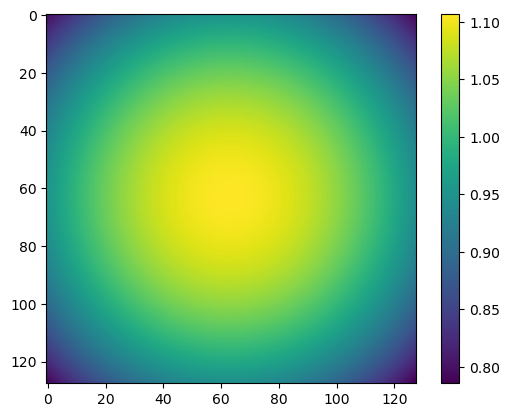

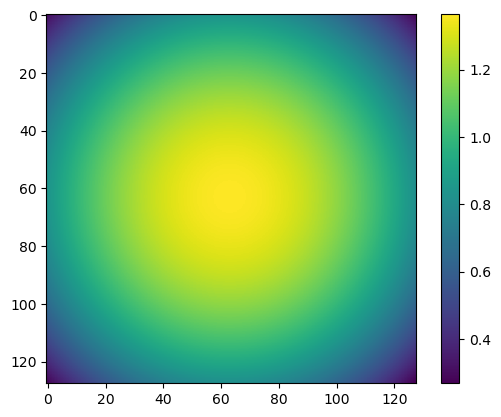

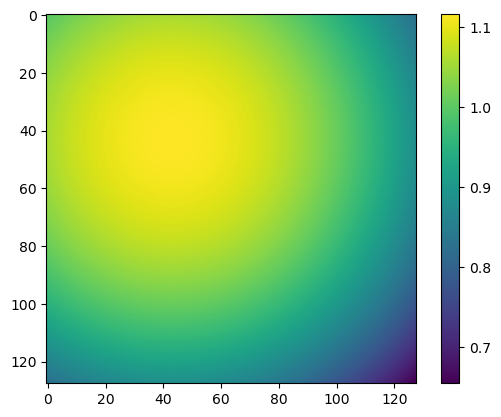

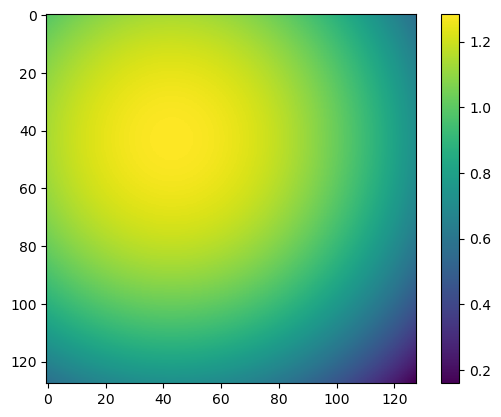

In [9]:
def generate_parabola(dim, coef, center):
    sizes = [128] * dim
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1 - c, size // 2 - c, size)
                for (c, size) in zip(center, sizes)
            ],
            indexing="ij"
        )
    )
    gradient = np.sum(grid**2, axis=0)
    gradient = coef * (np.max(gradient) - gradient) + 10
    return gradient / gradient.mean()


# Ground truth, for correctness checking

params = [
    (2, 0.0005, (0, 0)),
    (2, 0.005, (0, 0)),
    (2, 0.0005, (-20, -20)),
    (2, 0.005, (-20, -20)),
]

flatfield_profiles = [generate_parabola(*ps) for ps in params]

for p in flatfield_profiles:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

## Make images with blobs 

aim ... add random (uncorrelated) object that show intensity profile different from the fitted flatfield, see how it affects the fitting quality

In [10]:
blob_size = 2
blob_dist = lambda: np.random.normal(0, 2)

In [11]:
def generate_cluttered_images(
    true_flatfield, intensity, n_images, ave_count, blob_dist
):
    poss = np.array(
        [
            [
                np.random.uniform(
                    -size // 2 + 1,
                    size // 2,
                )
                for size in true_flatfield.shape
            ]
            for _ in range(np.random.poisson(ave_count))
        ]
    )

    images = []
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1, size // 2, size)
                for size in true_flatfield.shape
            ],
            indexing="ij"
        )
    )
    for _ in range(n_images):
        image = true_flatfield.copy()
        for p in poss:
            image += (
                np.exp(
                    -np.sum((grid - p[:, np.newaxis, np.newaxis]) ** 2, axis=0)
                    / 2.0
                    / blob_size**2
                )
                / np.sqrt(2 * np.pi * blob_size**2) ** 2
                * blob_dist()
            )
        image = image * intensity
        image = np.clip(image, 0, None)
        image = filters.gaussian(np.random.poisson(image),sigma=1,preserve_range=True)
        images.append(image)
    return np.array(images)

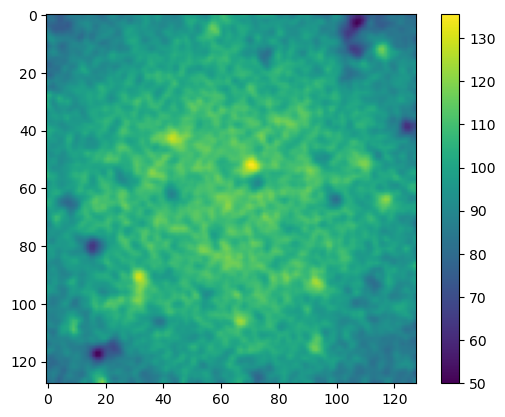

In [12]:
images = generate_cluttered_images(
    flatfield_profiles[0], 100, 100, 100, lambda: np.random.normal(0, 5)
)
plt.imshow(images[0])
plt.colorbar()

/tmp/ipykernel_248881/556527130.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  b.fit(np.array(images))


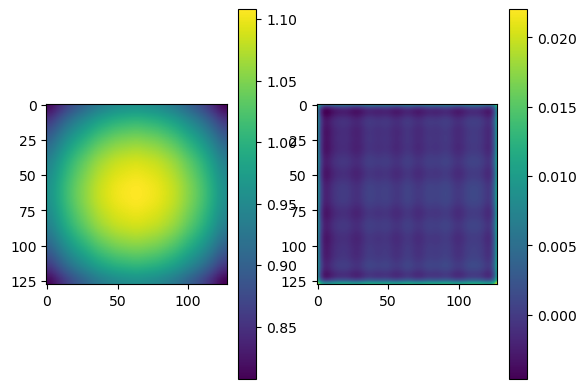

In [13]:
b = BaSiC(get_darkfield=False)
b.fit(np.array(images))
plt.subplot(121)
plt.imshow(b.flatfield)
plt.colorbar()
plt.subplot(122)
plt.imshow(b.flatfield / np.mean(b.flatfield) - flatfield_profiles[0])
plt.colorbar()

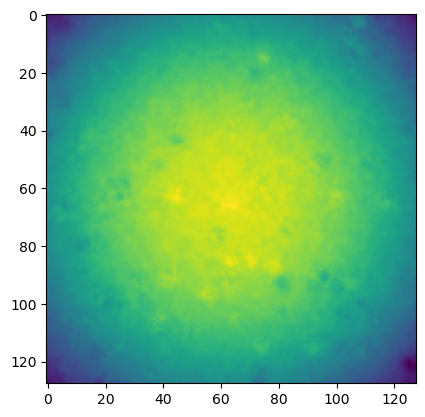

In [14]:
plt.imshow(np.median(images, axis=0))

In [ ]:
np.random.seed(202306)
repeat = 100
blob_dists = {
    "unbiased": lambda: np.random.normal(0, 5),
    "biased": lambda: np.random.normal(10, 5),
}
conditions = list(
    product(
        range(
            len(flatfield_profiles)
        ),  # true_flatfield_id (index of flatfield_profiles)
        [10, 100, 1000],  # intensity
        [10, 100],  # ave_count
        [10, 30, 100, 300, 1000],  # n_images
        ["biased", "unbiased"],  # blob_dist_key
        range(5)
    )
)

parameters = []
imagess = []
for (
    true_flatfield_id,
    intensity,
    ave_count,
    n_images,
    blob_dist_key,
    rep
) in tqdm(conditions):
    p = {
            "true_flatfield_id": true_flatfield_id,
            "intensity": intensity,
            "ave_count": ave_count,
            "n_images": n_images,
            "blob_dist_key": blob_dist_key,
            "rep":rep,
            }
    parameters.append(
        p
    )
    imagess.append(generate_cluttered_images(
        flatfield_profiles[true_flatfield_id],
        intensity=intensity,
        n_images=n_images,
        ave_count=ave_count,
        blob_dist=blob_dists[blob_dist_key],
    ))

  4%|██▋                                                                       | 44/1200 [01:05<2:05:17,  6.50s/it]

In [ ]:
#show_ray_progress(imagess)

In [ ]:
#imagess = ray.get(imagess)

In [ ]:
with open(path.join(workdir,"wo_darkfield_imagess.pickle"),"wb") as f:
    pickle.dump(imagess,f)

In [ ]:
with open(path.join(workdir,"wo_darkfield_imagess.pickle"),"rb") as f:
    imagess=pickle.load(f)

In [ ]:
pd.DataFrame.from_records(parameters).to_csv(path.join(workdir,"wo_darkfield_parameters.csv"))

In [ ]:
parameters_df=pd.read_csv(path.join(workdir,"wo_darkfield_parameters.csv"))

# Fit images

In [ ]:
jax.config.update('jax_platform_name', 'gpu')

In [ ]:
#parameters_df = pd.DataFrame.from_records(parameters)
#ind = (parameters_df["n_images"]<900).values
#parameters_df2 = parameters_df[ind].copy()
#imagess2 = [imagess[ii] for ii in np.nonzero(ind)[0]]
"""
assert len(parameters_df2) == len(imagess2)
with open("wo_darkfield_imagess2.pickle","wb") as f:
    pickle.dump(imagess2,f)
parameters_df2.to_csv("wo_darkfield_parameters2.csv")
"""

In [ ]:
flatfields = []
baselines = []
b = BaSiC(
    get_darkfield=False,
)
estimated_parameters = []
for p,images in tqdm(zip(parameters_df.to_dict(orient="records"),imagess),total=len(imagess)):
    for fitting_mode, smoothness_flatfield in product(
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-3, 1, 7)),  # smoothness_flatfield
    ):
        p2 = p.copy()
        p2.update({
            "fitting_mode": fitting_mode,
            "smoothness_flatfield": smoothness_flatfield,
        })
        b.fitting_mode=fitting_mode
        b.smoothness_flatfield=smoothness_flatfield
        b.fit(images)
        flatfields.append(b.flatfield)
        baselines.append(b.baseline)
        estimated_parameters.append(p2)
estimated_parameters_df = pd.DataFrame.from_records(estimated_parameters).reset_index(drop=True)

In [ ]:
np.save("flatfields.npy",flatfields)

# Calculate deviation

In [29]:
flatfields = np.load("flatfields.npy")

In [35]:
assert len(estimated_parameters_df) == len(flatfields)

In [36]:
for (i, row), flatfield in zip(estimated_parameters_df.iterrows(),flatfields):
    estimated_parameters_df.loc[i,"deviation"] = np.mean(np.abs(flatfield - flatfield_profiles[row["true_flatfield_id"]]))

In [37]:
if "Unnamed: 0" in estimated_parameters_df.keys():
    del estimated_parameters_df["Unnamed: 0"]

In [38]:
estimated_parameters_df.to_csv("wo_flatfield_estimated_parameters_df.csv")
estimated_parameters_df.head()

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,fitting_mode,smoothness_flatfield,deviation
0,0,10,10,10,biased,0,ladmap,0.001000,0.036881
1,0,10,10,10,biased,0,ladmap,0.004642,0.036452
2,0,10,10,10,biased,0,ladmap,0.021544,0.033683
3,0,10,10,10,biased,0,ladmap,0.100000,0.029211
4,0,10,10,10,biased,0,ladmap,0.464159,0.018625


In [ ]:
estimated_parameters_df = pd.read_csv("wo_flatfield_estimated_parameters_df.csv")

In [39]:
estimated_parameters_df.keys()

Index(['true_flatfield_id', 'intensity', 'ave_count', 'n_images',
       'blob_dist_key', 'rep', 'fitting_mode', 'smoothness_flatfield',
       'deviation'],
      dtype='object')

In [40]:
res_dir = "figs/wo_darkfields/"
os.makedirs(res_dir,exist_ok=True)

# Plot profiles

In [ ]:
for (intensity, ave_count, n_images, blob_dist_key), grp in tqdm(estimated_parameters_df.groupby(["intensity", "ave_count", "n_images","blob_dist_key"])):
    df = grp[grp["rep"]==0]
    smoothness_flatfields=df["smoothness_flatfield"].unique()
    ncol = len(smoothness_flatfields)
    nrow = int(len(df) / ncol)
    fig, axes = plt.subplots(nrow,ncol, figsize=(2*ncol,2*nrow))
    for irow, ((fitting_mode, true_flatfield_id), grp2) in enumerate(df.groupby(["fitting_mode","true_flatfield_id"])):
        df2=grp2.sort_values(["smoothness_flatfield",])
        assert len(axes[irow,:]) == len(df2)
        for ax, (j, row) in zip(axes[irow,:],df2.iterrows()):
            ax.imshow(flatfields[j])
            #ax.axis("off")
        axes[irow,0].set_ylabel(f"{fitting_mode}\nflatfield #{true_flatfield_id}",rotation=90)
    fig.tight_layout()
    fig.savefig(os.path.join(res_dir,f"intensity_{intensity}_ave-count_{ave_count}_n-images{n_images}_blob-dist_{blob_dist_key}.png"),bbox_inches="tight")